# SKOLTECH, Experimental Data Processing

## Evgenii Safronov, Mikhail Kurenkov, Taras Melnik

In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from numpy.linalg import inv
import matplotlib as mplb
from matplotlib.font_manager import FontProperties
%matplotlib inline
from numpy.random import normal
from mpl_toolkits.mplot3d import Axes3D
mplb.rc('xtick', labelsize=5) 
mplb.rc('ytick', labelsize=5) 

In [2]:
def generate_trajectory(sigma_w_2, sigma_n_2, M, X_0):
    sigma_w = sigma_w_2 ** 0.5
    sigma_n = sigma_n_2 ** 0.5
    w = np.random.normal(0, sigma_w, M)
    n = np.random.normal(0, sigma_n, M)

    x = w.dot(np.tril(np.ones((M, M)))) + X_0 * np.ones(M)
    z = x + n
    return x, z

def calculate_exp_w_n(z):
    v = z - np.roll(z,1)
    p = z - np.roll(z,2)
    E_v = np.average((v ** 2)[1:])
    E_p = np.average((p ** 2)[2:])
    return E_p - E_v, E_v - E_p / 2

def alpha_opt(sigma_w_2, sigma_n_2):
    chi = sigma_w_2 / sigma_n_2
    return (-chi + (chi**2 + 4 * chi) ** 0.5) / 2

def M_opt(alpha):
    return int(round((2 - alpha) / alpha))

def running_mean(z, M, mask=None):
    if mask is None:
        mask = np.ones(M) / M
    m = int(M/2)
    z_ext = np.zeros(len(z) + 2 * m)
    z_ext[:m] = np.flip(z[:m], 0)
    z_ext[-m:] = np.flip(z[-m:], 0)
    z_ext[m:-m] = z
    return np.convolve(z_ext, mask, mode="same")[m:-m]

def exp_mean(z, alpha):
    exp_mean_z = z.copy()
    for i in range(1, len(z)):
        exp_mean_z[i] = exp_mean_z[i - 1] + alpha * (z[i] - exp_mean_z[i - 1])
    return exp_mean_z

def backward_exp_mean(x_f, alpha):
    x_b = x_f.copy()
    for i in range(len(x_b)-2,-1,-1):
        x_b[i] = x_b[i+1] + alpha*(x_f[i] - x_b[i+1])
    return x_b

## Part 1:
## Comparison of the traditional 13 month running mean with the forward
## backward exponential smoothing for approximation of 11 year sunspot cycle

In [3]:
year, month, y = np.loadtxt("data_group6.txt", unpack=True) # y - sunspot number
x = year + month / 12 # x - months

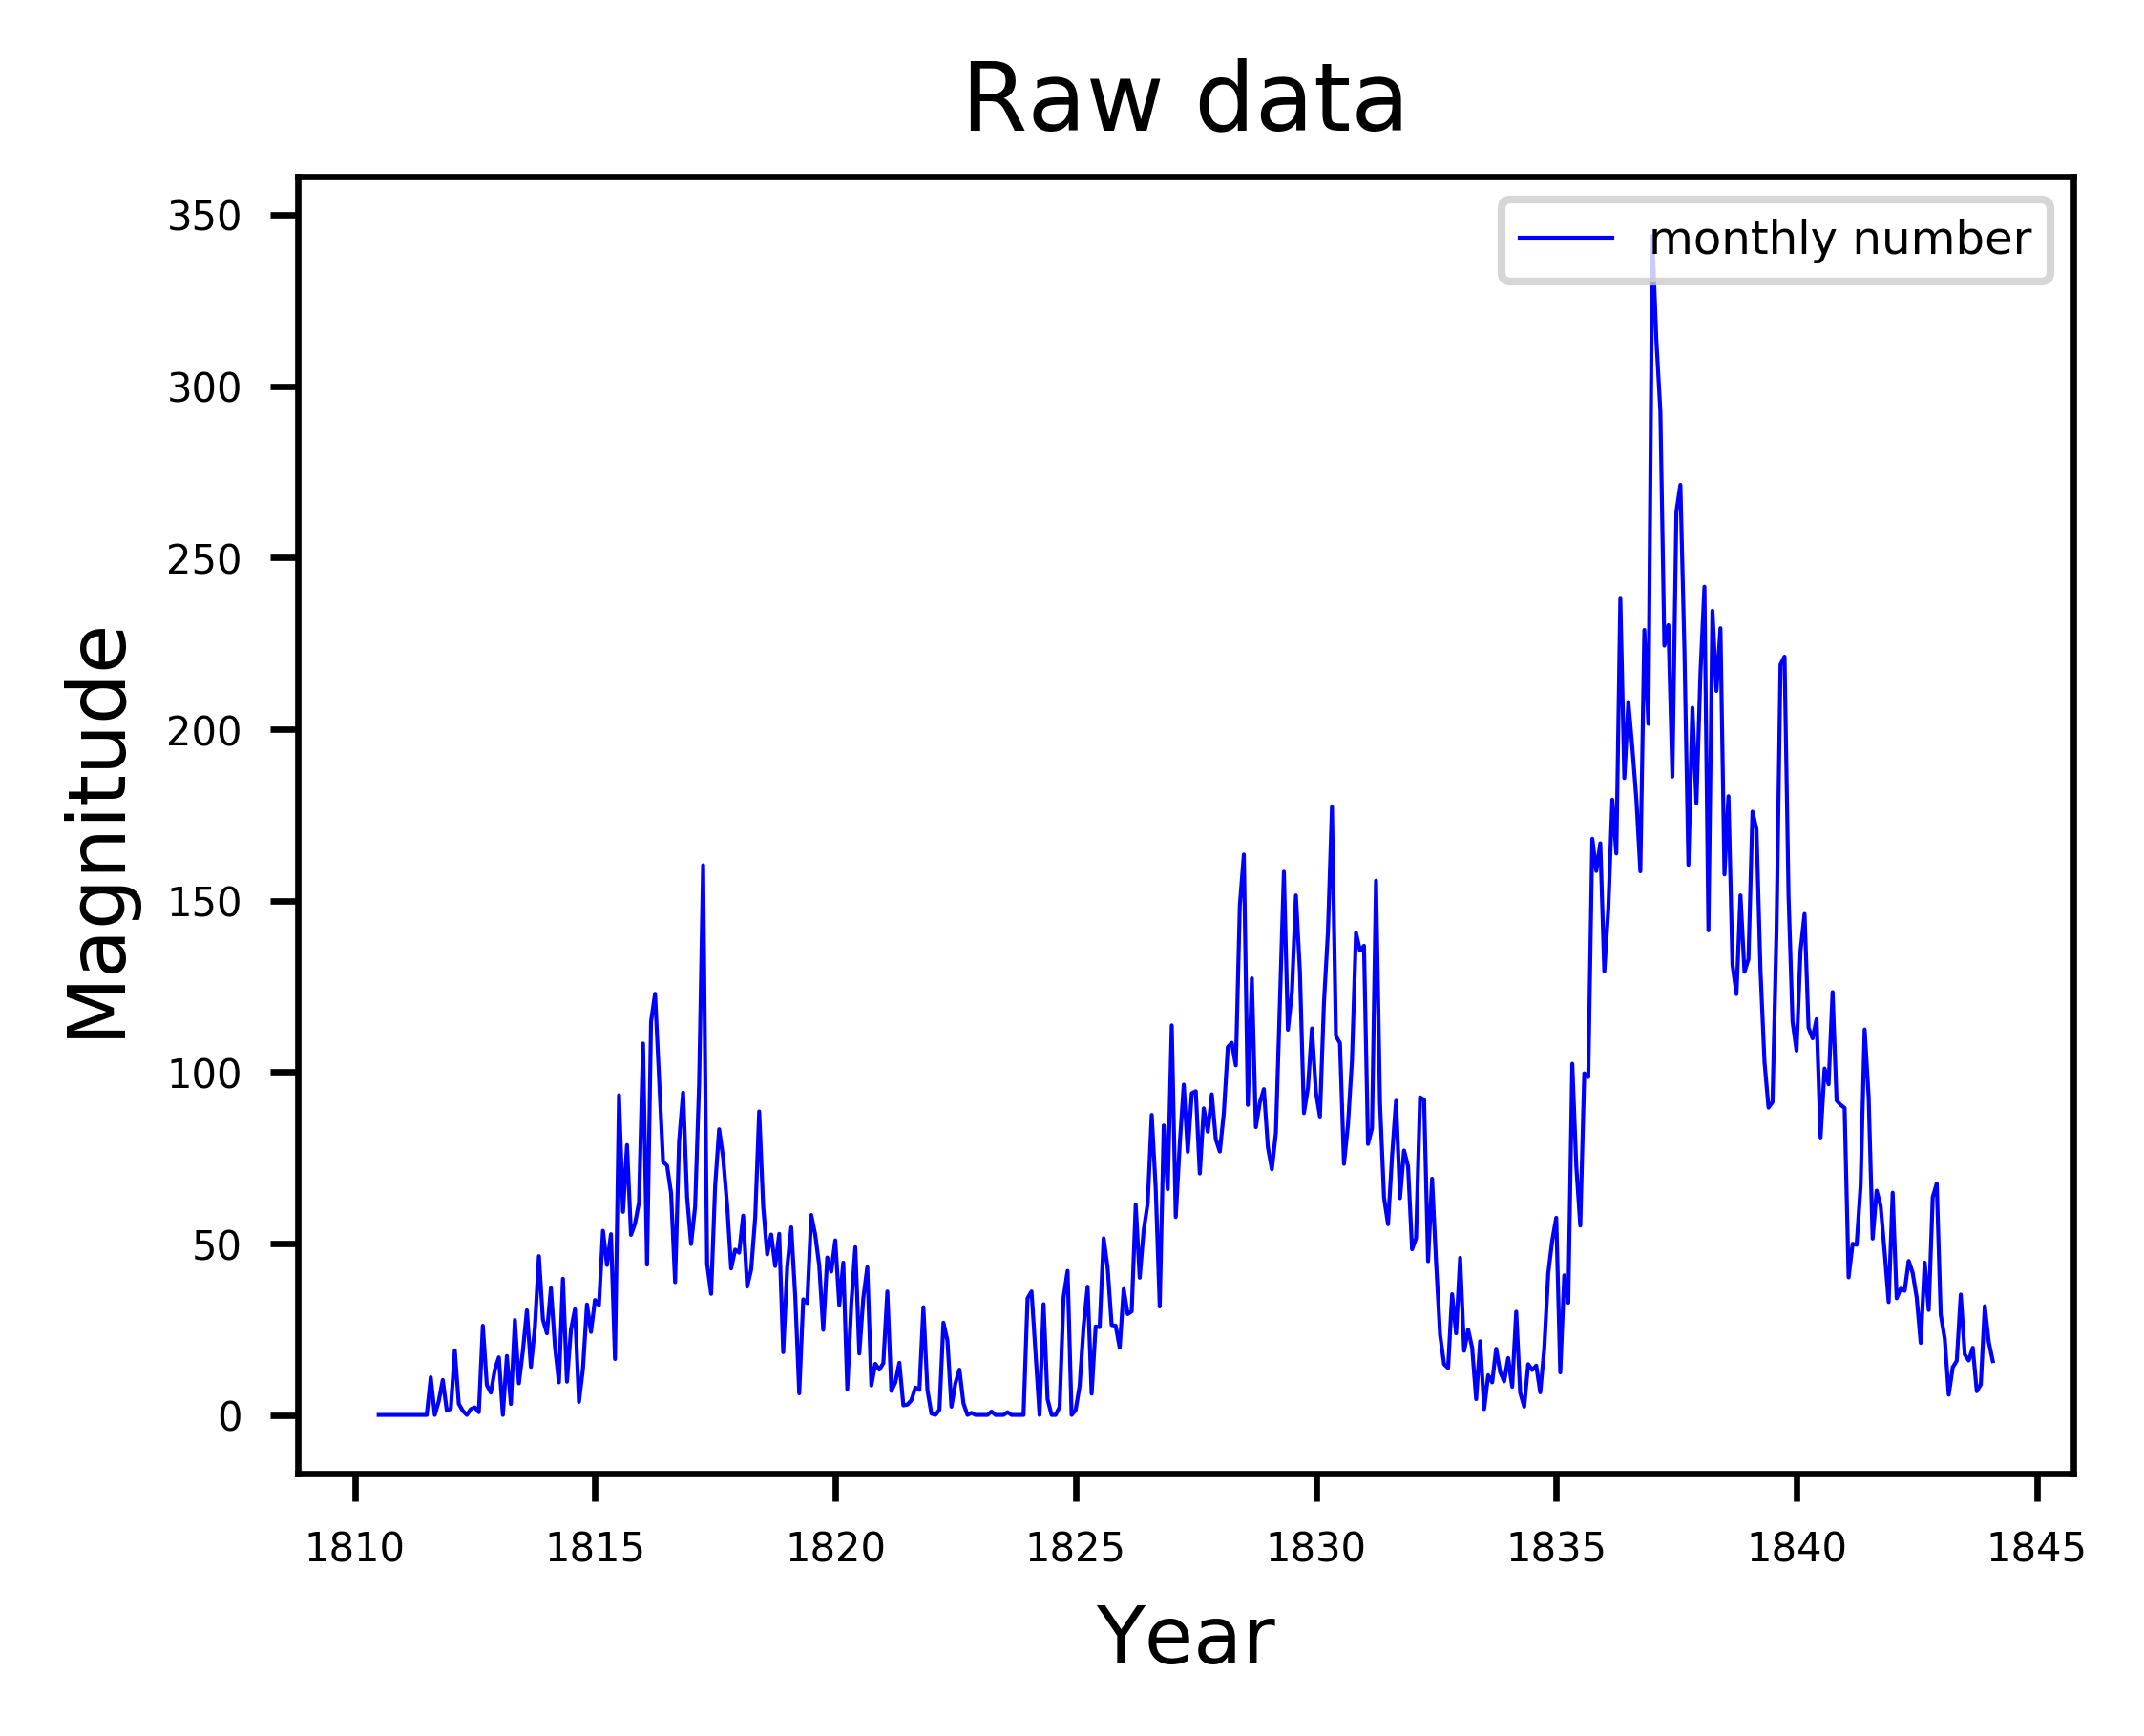

In [4]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi = 600)
ax.set_title('Raw data')
ax.plot(x, y,'b', label = 'monthly number', linewidth=0.5)
fontP = FontProperties()
fontP.set_size('xx-small')
ax.legend(prop = fontP, loc = 'upper right')
ax.set_xlabel('Year')
ax.set_ylabel('Magnitude');

### Running mean

In [5]:
y_mean = running_mean(y, 12, np.array([1/24] + list(np.ones(11) / 12) + [1/24]))

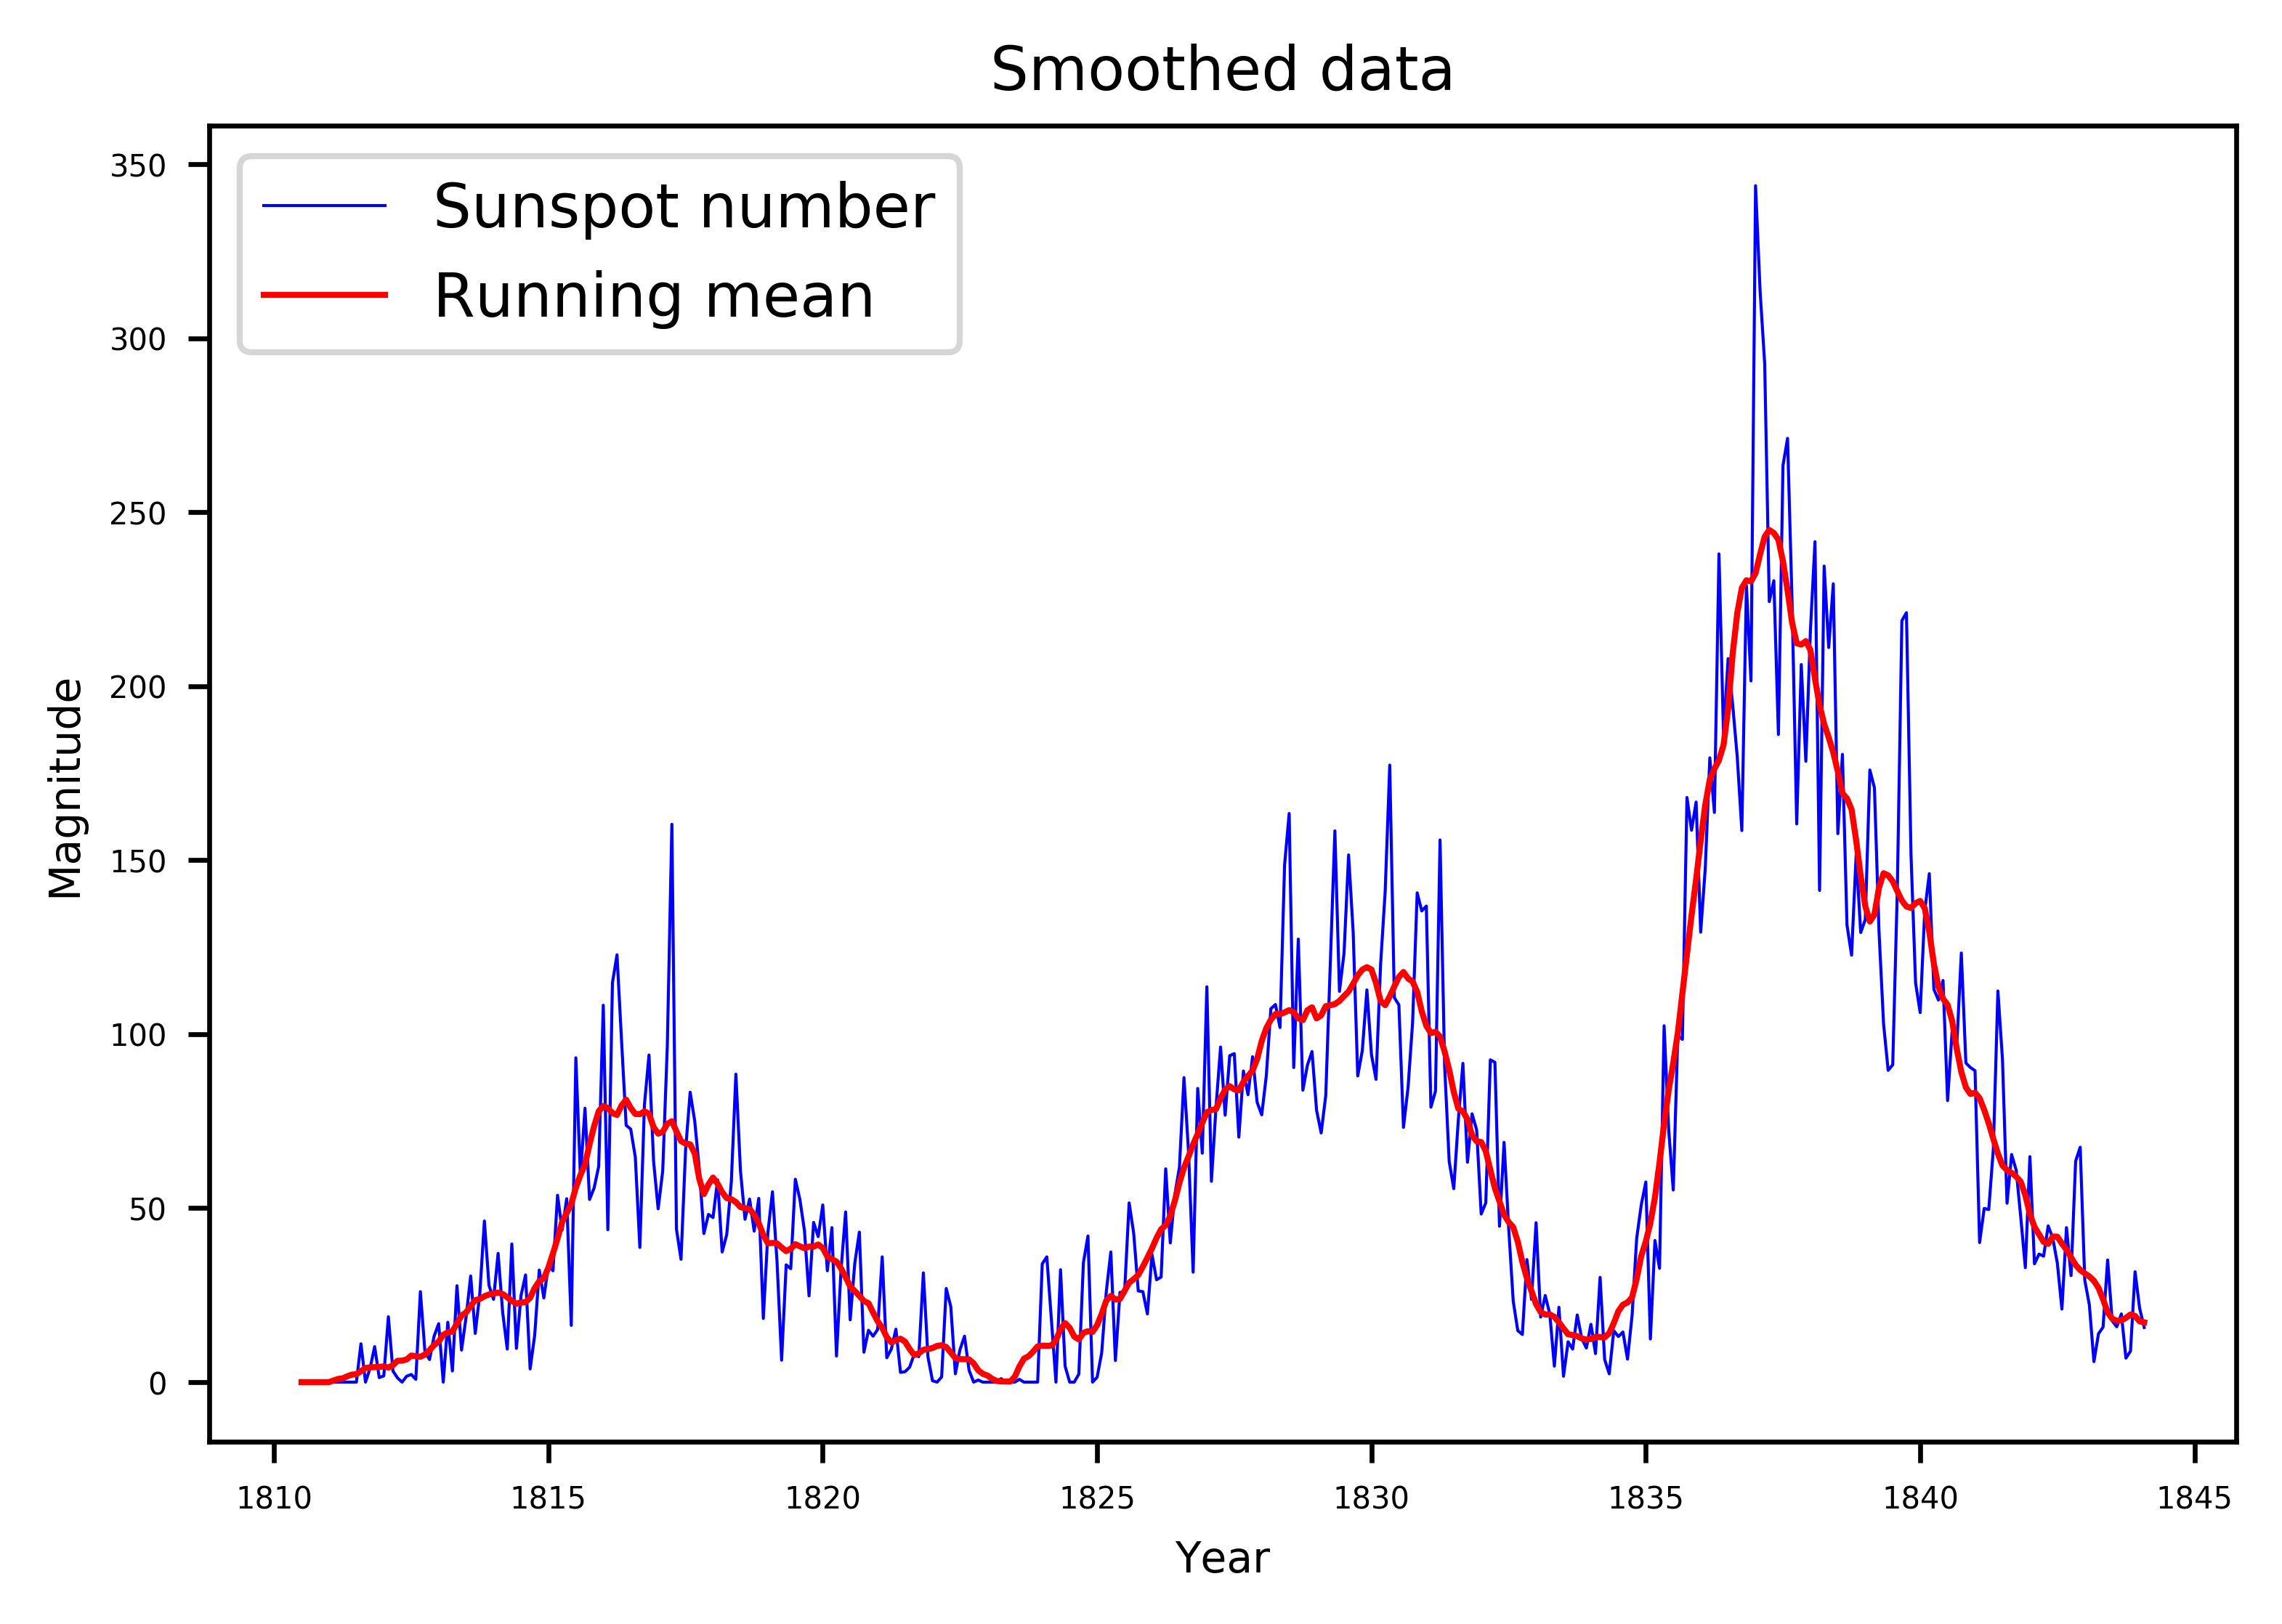

In [6]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi = 600)
ax.set_title('Smoothed data', fontsize = 10)

ax.plot(x, y,'b', label = r'Sunspot number', linewidth = 0.5 )
ax.plot(x, y_mean,'r', label = r'Running mean', linewidth = 1 )
ax.set_xlabel('Year', fontsize=7)
ax.set_ylabel('Magnitude', fontsize=7)
ax.legend(loc = 'upper left', fontsize=10);

### Exponential mean

In [7]:
def Id(z, x):
    return np.sum((z-x)**2)

def Iv(x):
    return np.sum((np.roll(x,-2) - 2 * np.roll(x,-1) + x)[:-2]**2)

In [8]:
print("For running mean Id = %f, Iv = %f" % (Id(y, y_mean), Iv(y_mean)))

For running mean Id = 193951.331979, Iv = 1403.096250


In [9]:
alphas = np.arange(0.01, 0.2, 0.001)
Id_exp = []
Iv_exp = []
for alpha in alphas:
    y_exp_bf = backward_exp_mean(exp_mean(y, alpha), alpha)
    Id_exp.append(Id(y, y_exp_bf))
    Iv_exp.append(Iv(y_exp_bf))

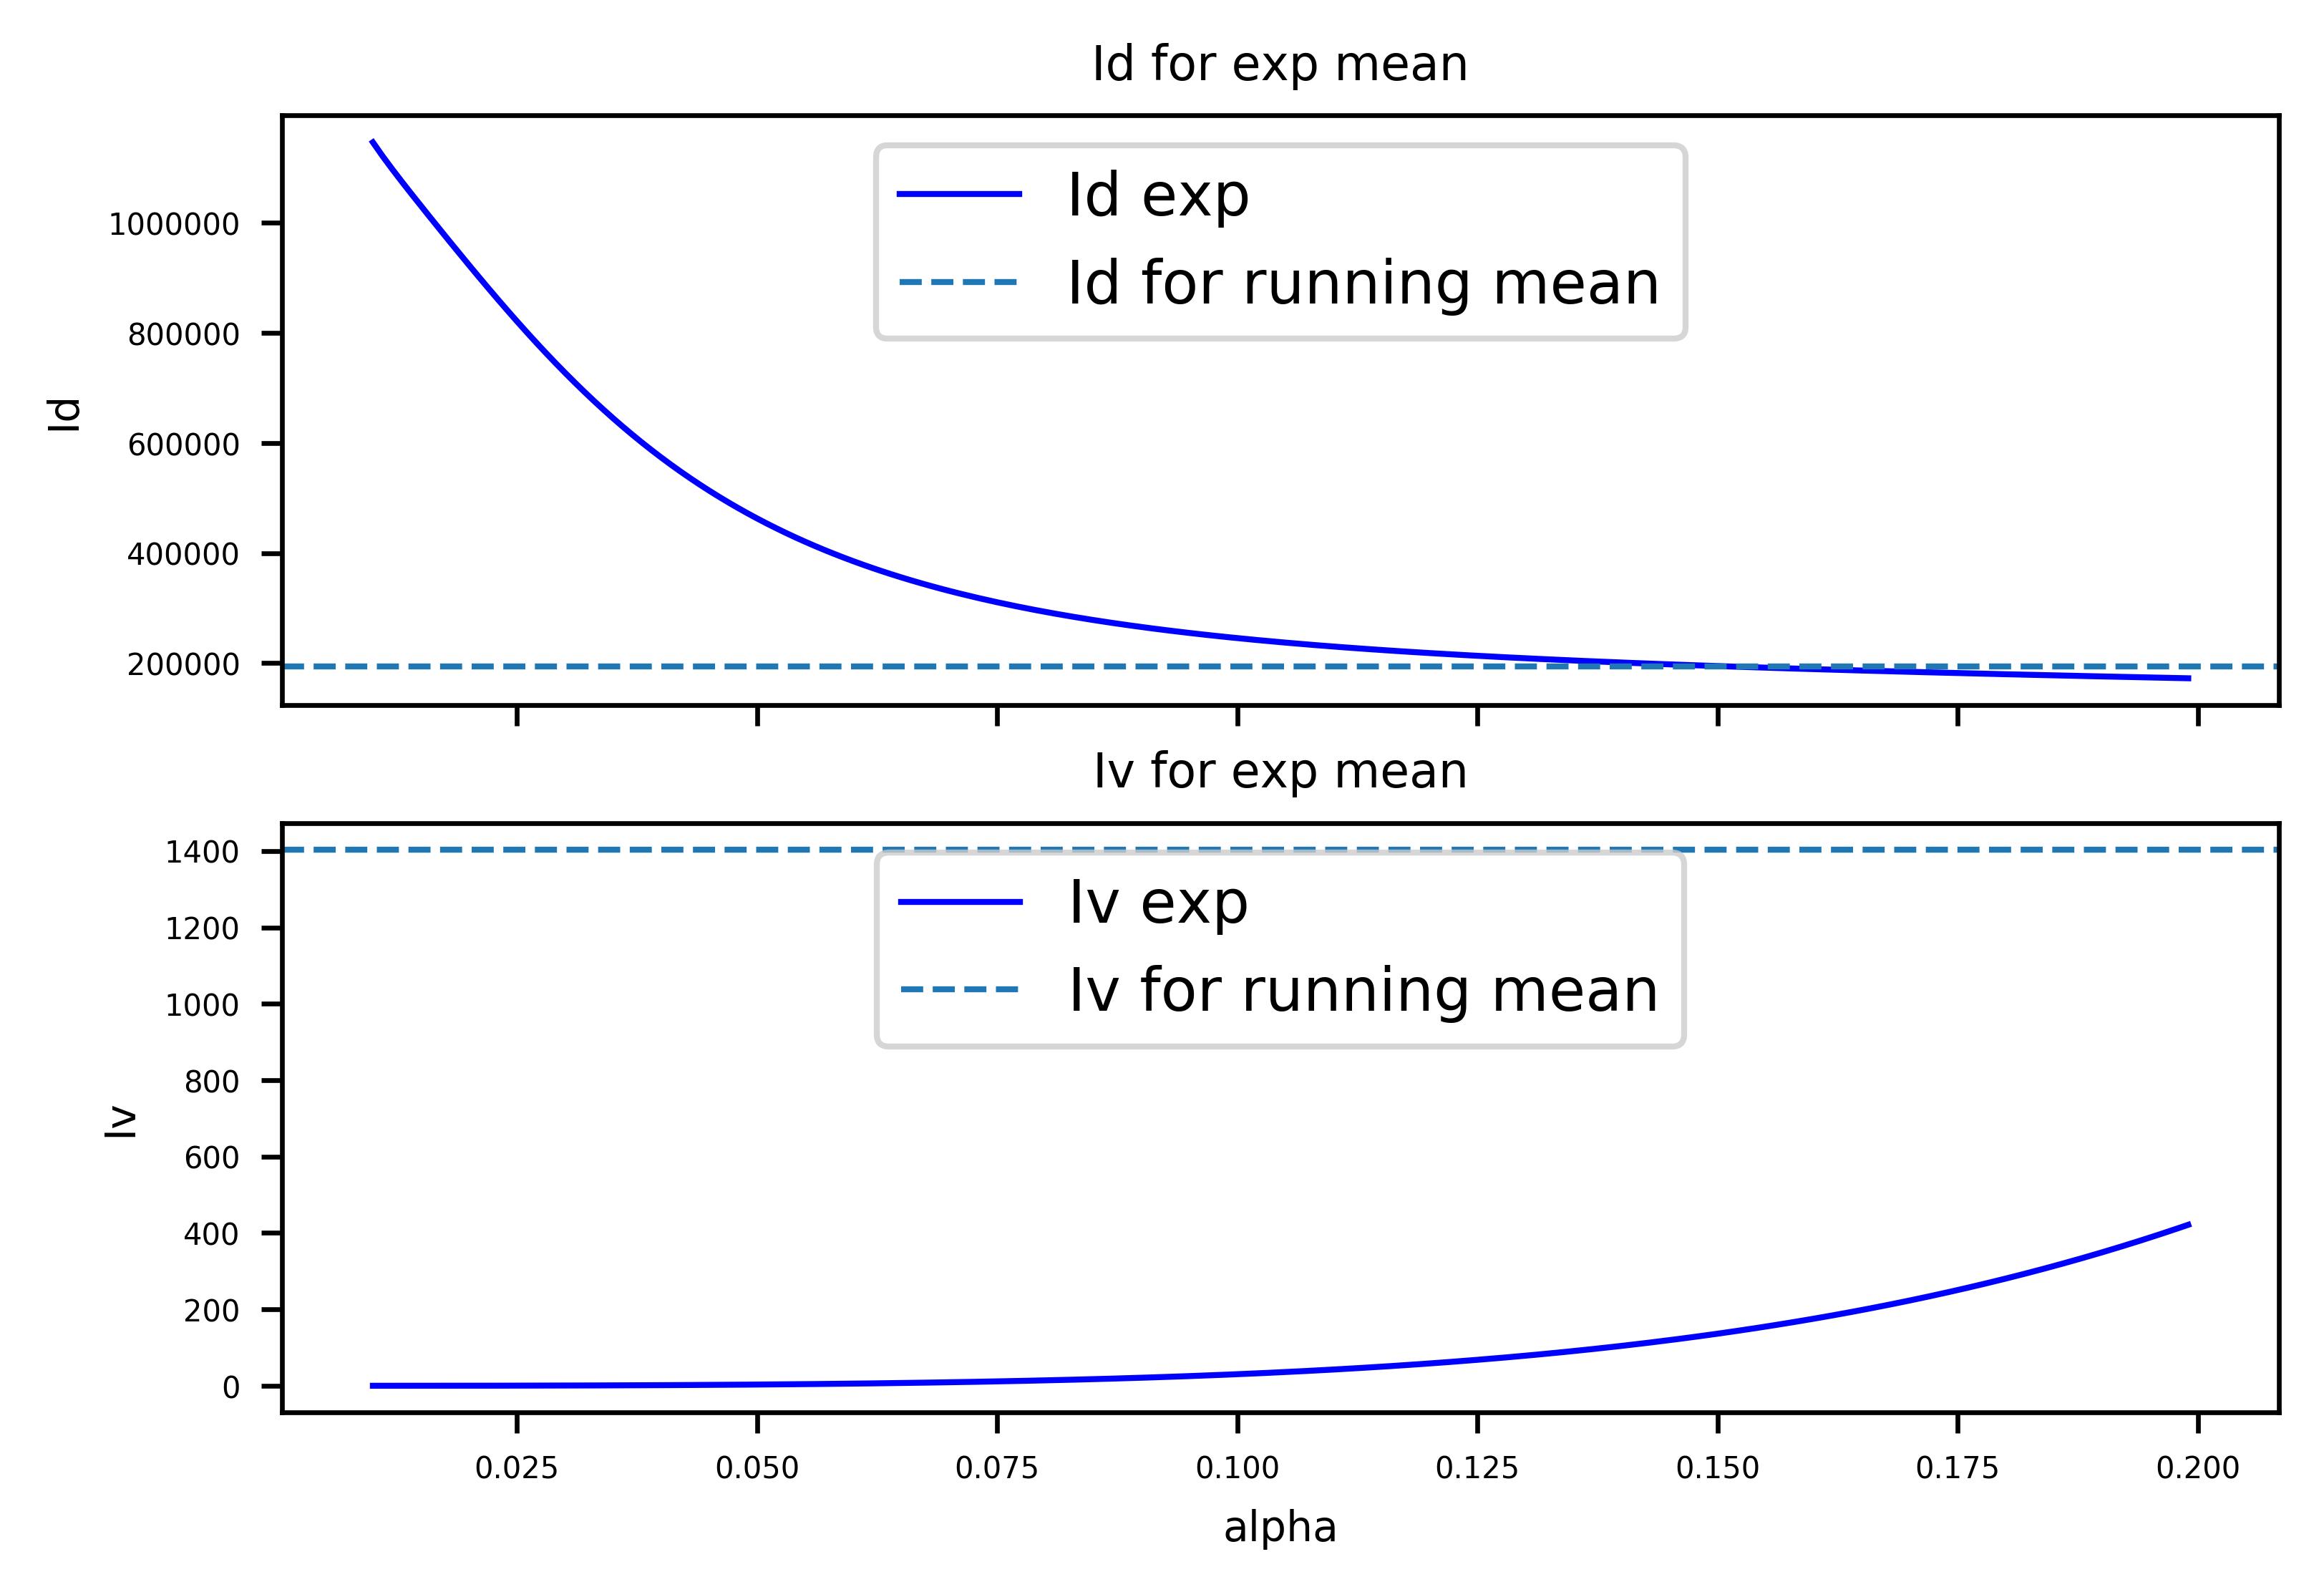

In [10]:
fig, ax = plt.subplots(2,1, figsize=(6,4), dpi = 600, sharex=True)
ax[0].set_title('Id for exp mean', fontsize = 8)
ax[0].plot(alphas, Id_exp,'b', label = 'Id exp', linewidth=1)
ax[0].axhline(y=Id(y, y_mean), label = 'Id for running mean', linewidth=1, linestyle='dashed')
ax[0].set_ylabel('Id', fontsize = 7)
ax[0].legend(loc="upper center", fontsize=10);

ax[1].set_title('Iv for exp mean', fontsize = 8)
ax[1].plot(alphas, Iv_exp,'b', label = 'Iv exp', linewidth = 1)
ax[1].axhline(y=Iv(y_mean), label = 'Iv for running mean', linewidth=1, linestyle='dashed')
ax[1].set_xlabel('alpha', fontsize = 7)
ax[1].set_ylabel('Iv', fontsize = 7)
ax[1].legend(loc="upper center", fontsize=10);

### As it shown on the plot Iv coefficient for running mean is always more than same coefficient for forward-backward exponential mean.
### And Id coefficient for running mean is smaller than same coefficient for forward-backward exponential mean when alpha is smaller than 0.15.
### So if we take alpha > 0.15 we get both Id and Iv coefficient better for forward-backward exponential mean than running mean.

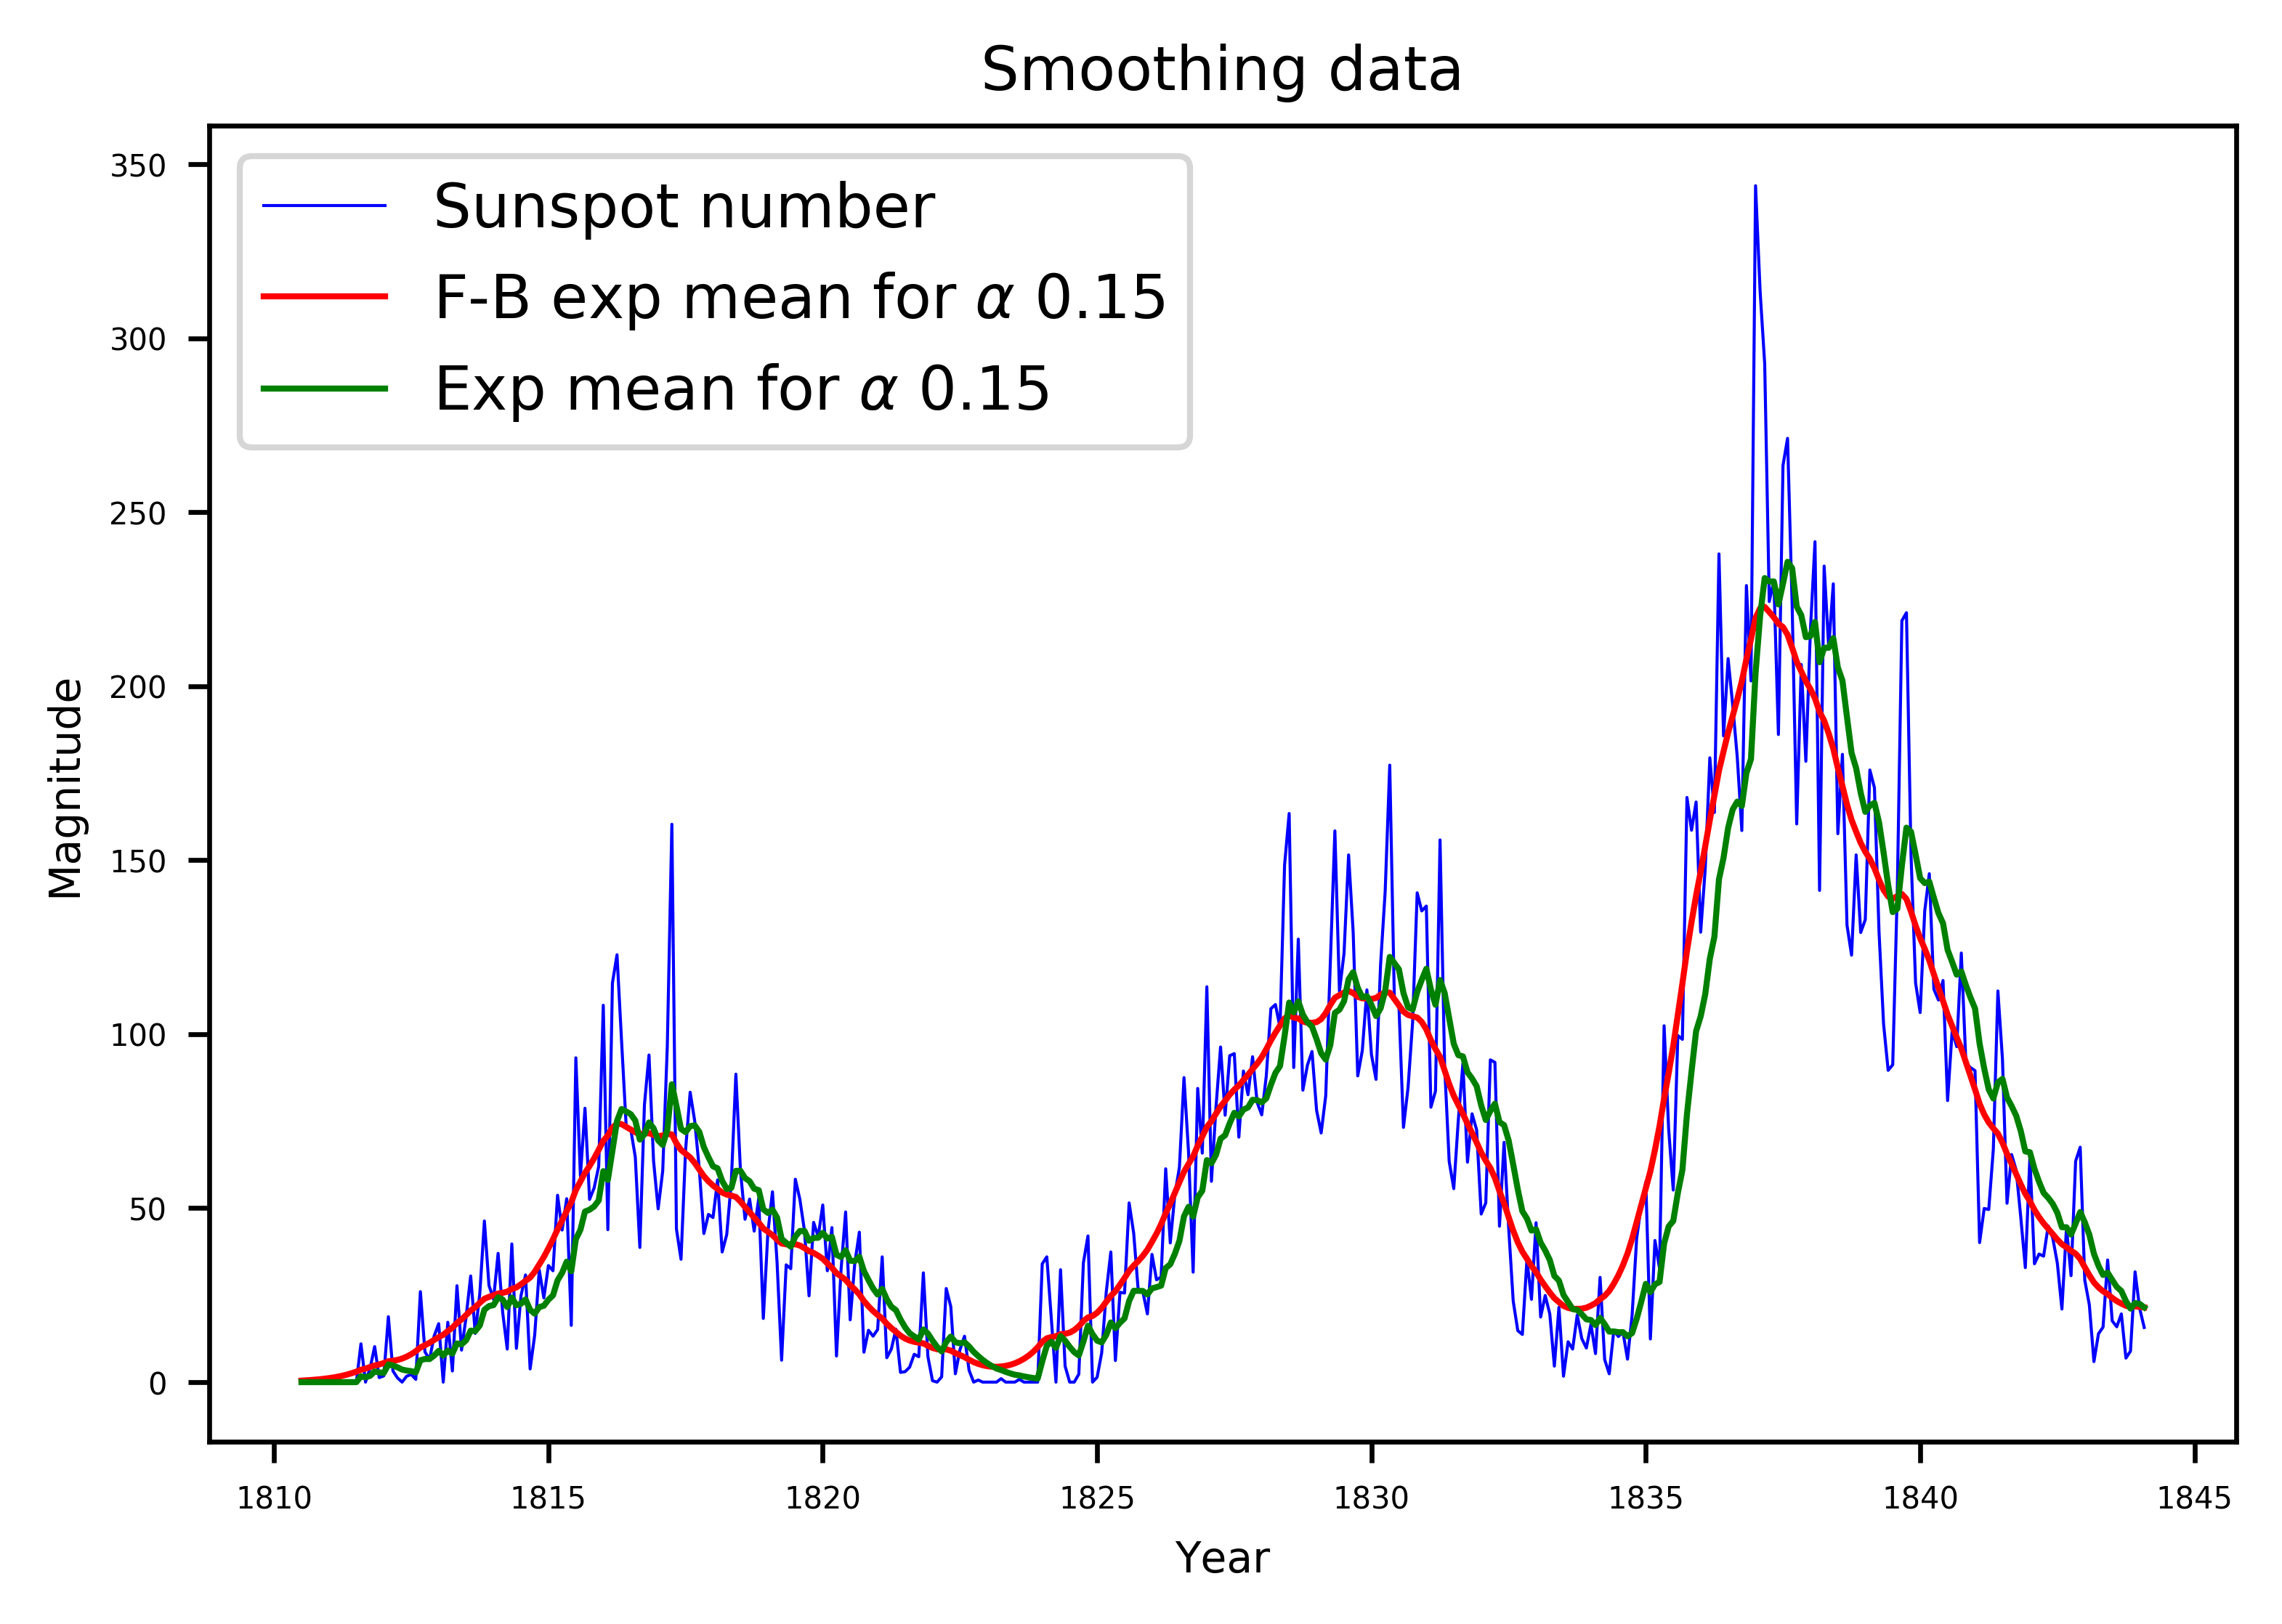

In [11]:
alpha = 0.15
y_exp_bf = backward_exp_mean(exp_mean(y, alpha), alpha)
y_exp = exp_mean(y, alpha)

fig, ax = plt.subplots(1,1, figsize=(6,4), dpi = 600)
ax.set_title('Smoothing data', fontsize = 10)

ax.plot(x, y,'b', label = r'Sunspot number', linewidth = 0.5 )
ax.plot(x, y_exp_bf,'r', label = r'F-B exp mean for $\alpha$ %.2f' % (alpha), linewidth = 1 )
ax.plot(x, y_exp,'g', label = r'Exp mean for $\alpha$ %.2f' % (alpha), linewidth = 1 )
ax.set_xlabel('Year', fontsize=7)
ax.set_ylabel('Magnitude', fontsize=7)
ax.legend(loc = 'upper left', fontsize=10);

## Part 2:
## 3d surface filtration using forward-backward smoothing

In [12]:
def fb_exp_mean_surface(z, alpha):
    z_fb_exp = z.copy()
    for i in range(z.shape[0]):
        z_fb_exp[i] = backward_exp_mean(exp_mean(z_fb_exp[i], alpha), alpha)
    z_fb_exp_mean_tr = z_fb_exp.transpose()
    for i in range(z.shape[0]):
        z_fb_exp_mean_tr[i] = backward_exp_mean(exp_mean(z_fb_exp_mean_tr[i], alpha), alpha)
    return z_fb_exp_mean_tr.transpose()

In [13]:
z_true = np.loadtxt("true_surface.txt")
z_noisy = np.loadtxt("noisy_surface.txt")
N = z_true.shape[0]
y, x = np.meshgrid(np.arange(N), np.arange(N))

In [14]:
def colors_for_graph(z):
    return mplb.cm.jet((z-z.min())/(z.max()-z.min()))

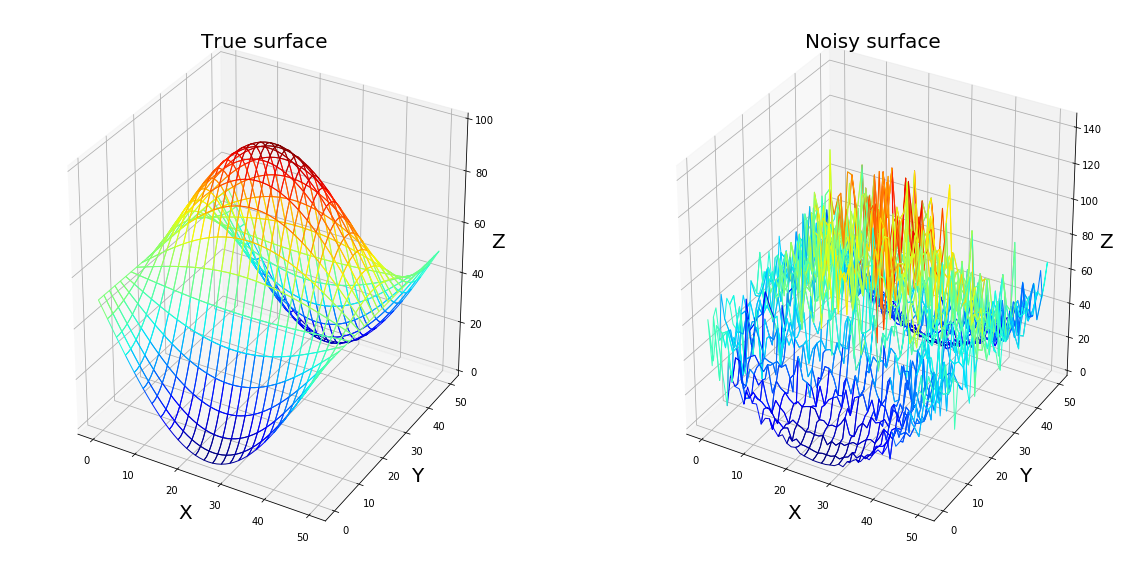

In [15]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(121, projection='3d')
ax.set_title('True surface', fontsize = 20)
surf = ax.plot_surface(x, y, z_true, facecolors = colors_for_graph(z_true), shade=False)
surf.set_facecolors((0, 0, 0, 0))
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.zaxis.set_tick_params(labelsize=10)
ax.set_xlabel('X', fontsize=20)
ax.set_ylabel('Y', fontsize=20)
ax.set_zlabel('Z', fontsize=20)

ax = fig.add_subplot(122, projection='3d')
surf = ax.plot_surface(x, y, z_noisy, facecolors = colors_for_graph(z_noisy), shade=False)
surf.set_facecolor((0,0,0,0))
ax.set_title('Noisy surface', fontsize = 20)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.zaxis.set_tick_params(labelsize=10)
ax.set_xlabel('X', fontsize=20)
ax.set_ylabel('Y', fontsize=20)
ax.set_zlabel('Z', fontsize=20);

In [16]:
print("Variance for noisy data is %f" % (np.var(z_noisy - z_true)))

Variance for noisy data is 122.591708


In [17]:
alphas = np.arange(0.01, 1, 0.01)
vs = []
for alpha in alphas:
    z_fb_exp = fb_exp_mean_surface(z_noisy, alpha)
    vs.append(np.var(z_fb_exp - z_true))

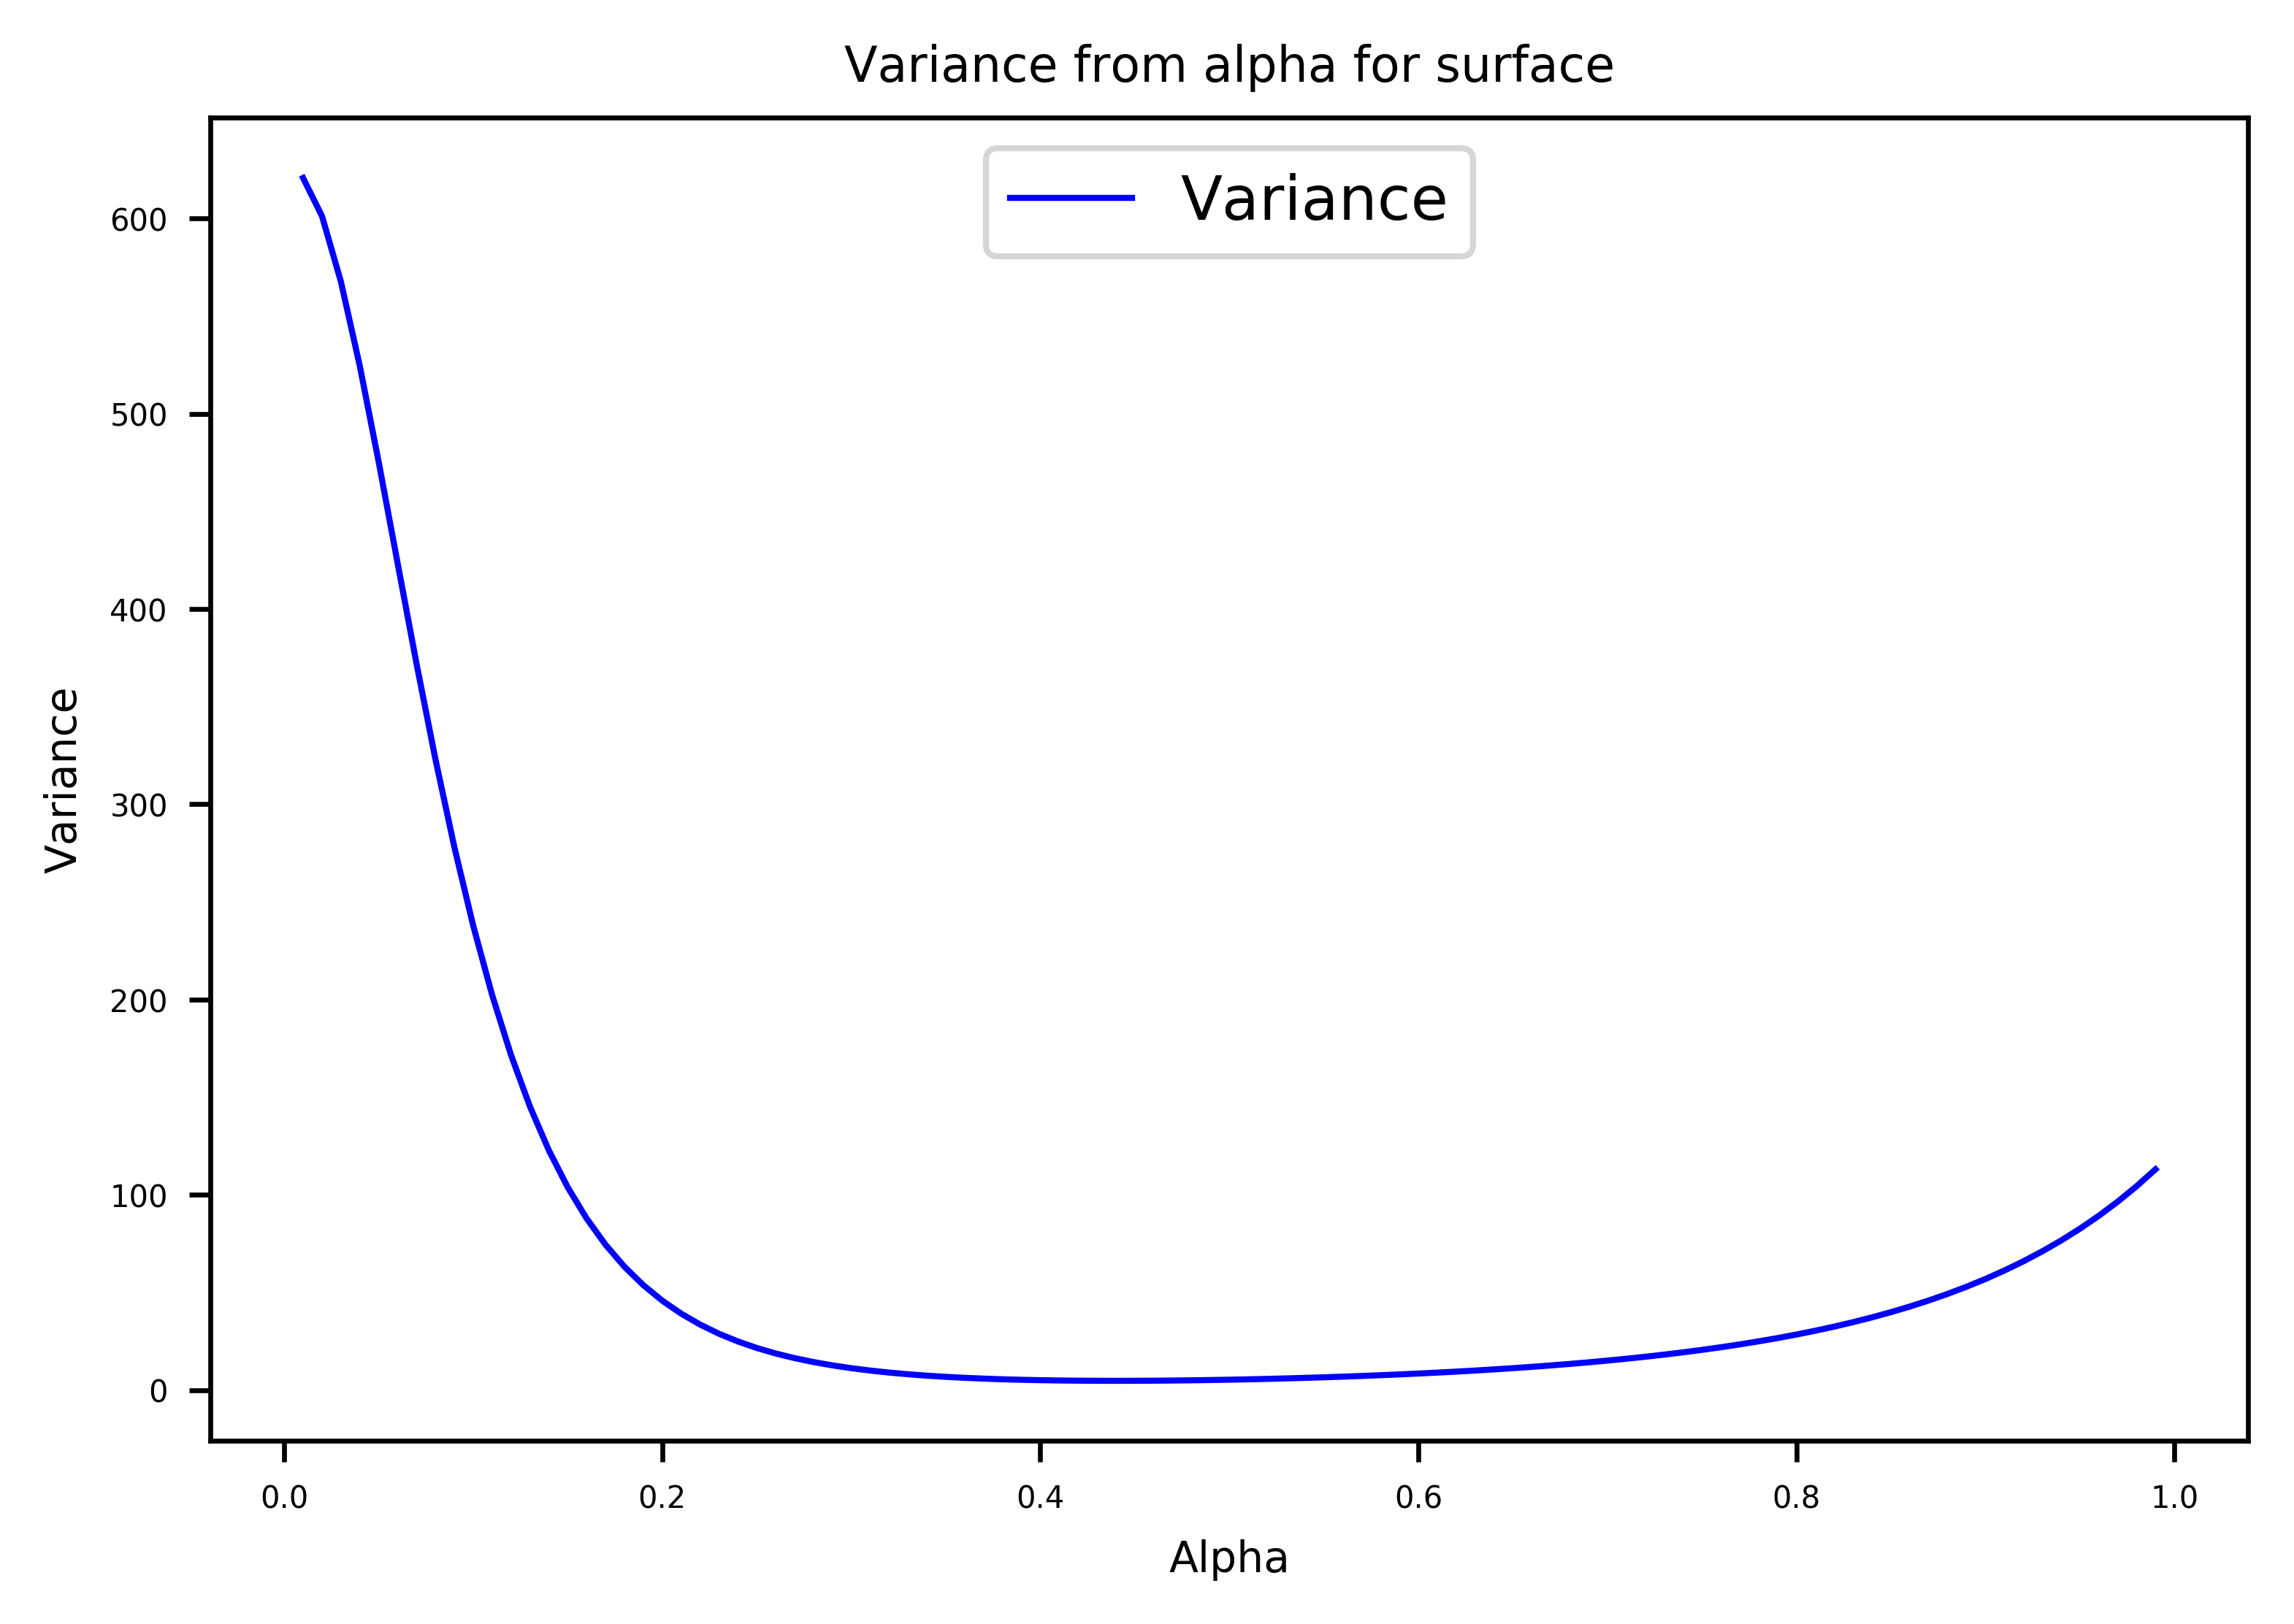

In [18]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi = 600)
ax.set_title('Variance from alpha for surface', fontsize = 8)
ax.plot(alphas, vs,'b', label = 'Variance', linewidth=1)
ax.set_ylabel('Variance', fontsize = 7)
ax.set_xlabel('Alpha', fontsize = 7)
ax.legend(loc="upper center", fontsize=10);

### From graph it is seen that variance is small from 0.3 to 0.7 

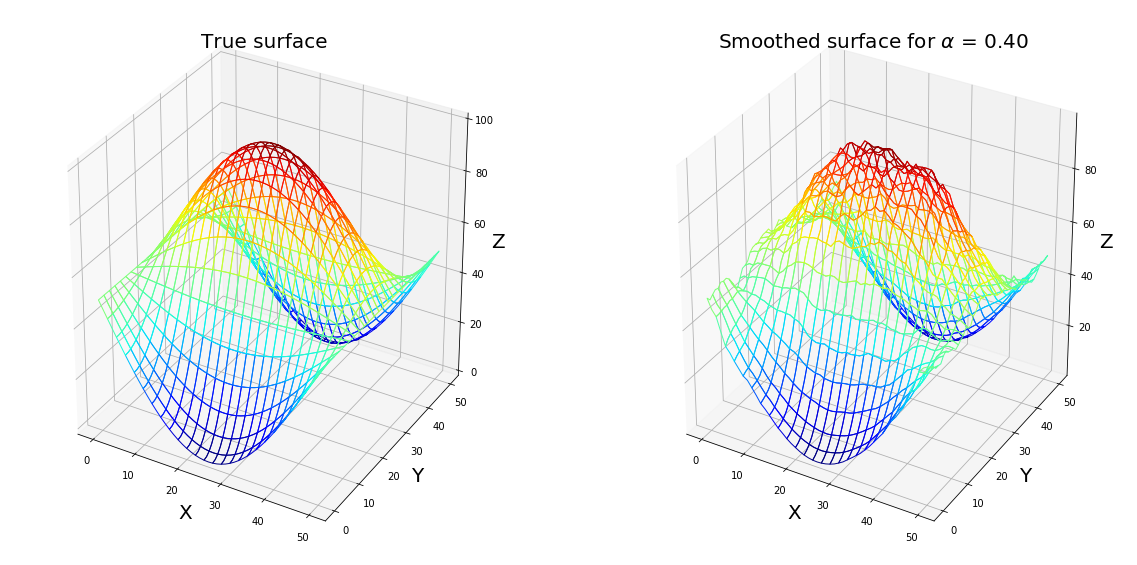

In [19]:
alpha = 0.4
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(121, projection='3d')
ax.set_title('True surface', fontsize = 20)
surf = ax.plot_surface(x, y, z_true, facecolors = colors_for_graph(z_true), shade=False)
surf.set_facecolors((0, 0, 0, 0))
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.zaxis.set_tick_params(labelsize=10)
ax.set_xlabel('X', fontsize=20)
ax.set_ylabel('Y', fontsize=20)
ax.set_zlabel('Z', fontsize=20)

ax = fig.add_subplot(122, projection='3d')
z_smooth = fb_exp_mean_surface(z_noisy, alpha)
surf = ax.plot_surface(x, y, z_smooth, facecolors = colors_for_graph(z_smooth), shade=False)
surf.set_facecolor((0,0,0,0))
ax.set_title(r'Smoothed surface for $\alpha$ = %.2f' % (alpha), fontsize = 20)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.zaxis.set_tick_params(labelsize=10)
ax.set_xlabel('X', fontsize=20)
ax.set_ylabel('Y', fontsize=20)
ax.set_zlabel('Z', fontsize=20);

# Today we learn forward-drawback exp mean for surface